Author: Shan Qu, Delft University of Technology

First created: 4 April 2021; latest modifed: 7 April 2021

Product: credit modeling --- training the model using Random forest


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

%run helpers.ipynb

pd.set_option('display.max_columns', 20)
seed = 143

import warnings
warnings.filterwarnings("ignore")

model = RandomForestClassifier()

In [ ]:
df_X_train = pd.read_csv('Data/df_X_train.csv')
df_X_val = pd.read_csv('Data/df_X_val.csv')
df_y_train = pd.read_csv('Data/df_y_train.csv')
df_y_val = pd.read_csv('Data/df_y_val.csv')
print(df_X_train.info())
print(df_y_train.info())

# drop the unnamed ID column
df_X_train.drop('Unnamed: 0', axis=1, inplace=True)
df_X_val.drop('Unnamed: 0', axis=1, inplace=True)
df_y_train.drop('Unnamed: 0', axis=1, inplace=True)
df_y_val.drop('Unnamed: 0', axis=1, inplace=True)

df_X_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         506 non-null    int64  
 1   duration           506 non-null    float64
 2   credit_amount      506 non-null    float64
 3   installment_rate   506 non-null    float64
 4   residence_length   506 non-null    float64
 5   age                506 non-null    float64
 6   existing_credits   506 non-null    float64
 7   liable_people      506 non-null    float64
 8   checking_account   506 non-null    float64
 9   credit_history     506 non-null    float64
 10  purpose            506 non-null    float64
 11  savings_account    506 non-null    float64
 12  employment_length  506 non-null    float64
 13  status_sex         506 non-null    float64
 14  other_debtors      506 non-null    float64
 15  property           506 non-null    float64
 16  installment_plan   506 non

,duration,credit_amount,installment_rate,residence_length,age,existing_credits,liable_people,checking_account,credit_history,purpose,savings_account,employment_length,status_sex,other_debtors,property,installment_plan,housing,job,telephone,foreign_worker
0,0.294118,0.269616,1.0,1.000000,0.250000,0.000000,0.0,0.0,0.000000,0.636409,1.000000,0.157661,0.000000,0.436055,0.424937,0.0,0.0,0.235904,0.0,1.0
1,0.647059,0.687741,1.0,0.000000,0.321429,0.000000,0.0,0.0,0.324712,0.335297,0.211197,0.000000,0.000000,0.436055,0.424937,0.0,0.0,1.000000,0.0,1.0
2,0.470588,0.155662,1.0,1.000000,0.303571,0.000000,0.0,0.0,0.326222,0.818572,0.212304,0.452020,0.000000,0.436055,0.000000,0.0,0.0,0.235904,1.0,1.0
3,0.073529,0.048861,1.0,1.000000,0.107143,0.333333,0.0,1.0,0.000000,0.335297,1.000000,0.452020,0.000000,0.436055,0.000000,0.0,0.0,0.000000,1.0,1.0
4,0.088235,0.035435,1.0,0.666667,0.375000,0.000000,0.0,0.0,0.326222,0.000000,0.212304,0.000000,0.637758,0.436055,0.419563,0.0,0.0,0.235904,0.0,1.0


## 3. Credit modeling

#### 3.1 Tune hyperparameters via GridSearchCV

Random Forest

max_depth (max number of levels in each decision tree) : [3, 5, 7, 9, None]

n_estimators (number of trees in the foreset) : [5, 10, 25, 50, 100, 200, 300, 500]

max_features (max number of features considered for splitting a node) : ['sqrt', 'log2'] 

min_samples_leaf: [1, 2, 4],


In [ ]:
model = RandomForestClassifier()
hyperparam_grid_1 = {'n_estimators': [25, 50, 100, 200, 300, 500, 700, 1000]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_1, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)


Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.4min finished


0.7900333205177497
{'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
model = RandomForestClassifier(n_estimators=500)
hyperparam_grid_2 = {'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_2, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

model_bestparam = grid_search.best_estimator_
print(model_bestparam)

Fitting 15 folds for each of 24 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  5.5min finished


0.7928084070229399
{'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       m

### 3.2 Fit the model using the selected hyperparameters and predict PD using the validation data

[[84 69]
 [ 6 41]]
              precision    recall  f1-score   support

        good       0.93      0.55      0.69       153
         bad       0.37      0.87      0.52        47

    accuracy                           0.62       200
   macro avg       0.65      0.71      0.61       200
weighted avg       0.80      0.63      0.65       200

0.7106800166875261


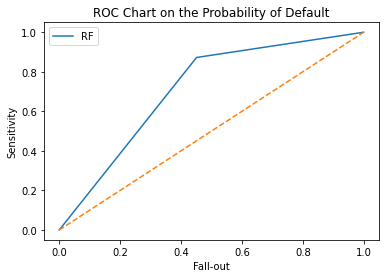

In [ ]:
preds = model_bestparam.predict_proba(df_X_val)
df_preds = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.4
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds['Risk_pred']))
print(classification_report(df_y_val, df_preds['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds['Risk_pred']))

plot_roc_PD(df_preds['Risk_pred'], df_y_val, 'RF')
plt.show()

### 3.3 Select proper threshold
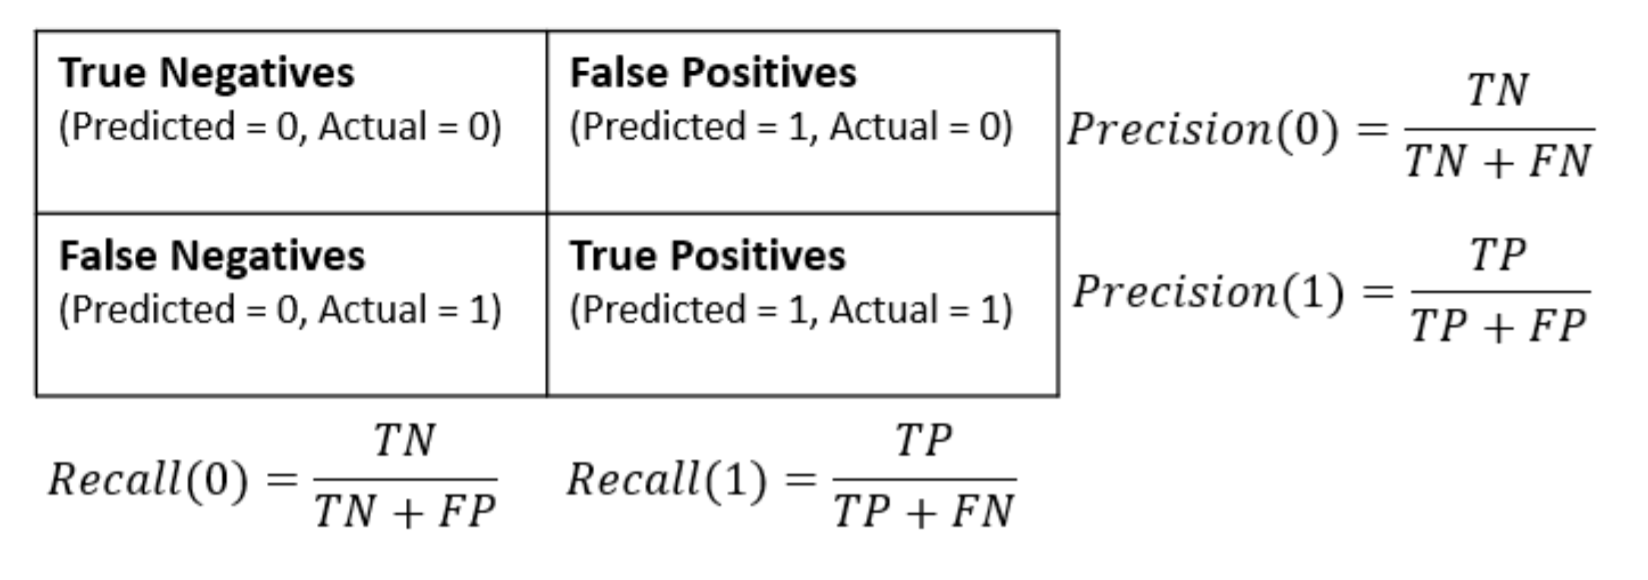

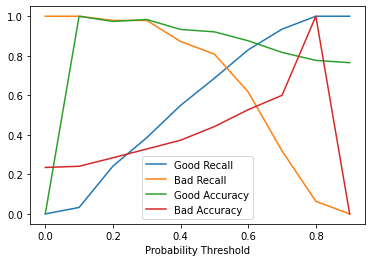

threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management


In [ ]:
plot_prob_thresh(df_preds, df_y_val)
plt.show()

print("threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management")

### 3.4 Feature selection using feature_importances of the trained Random forest tree

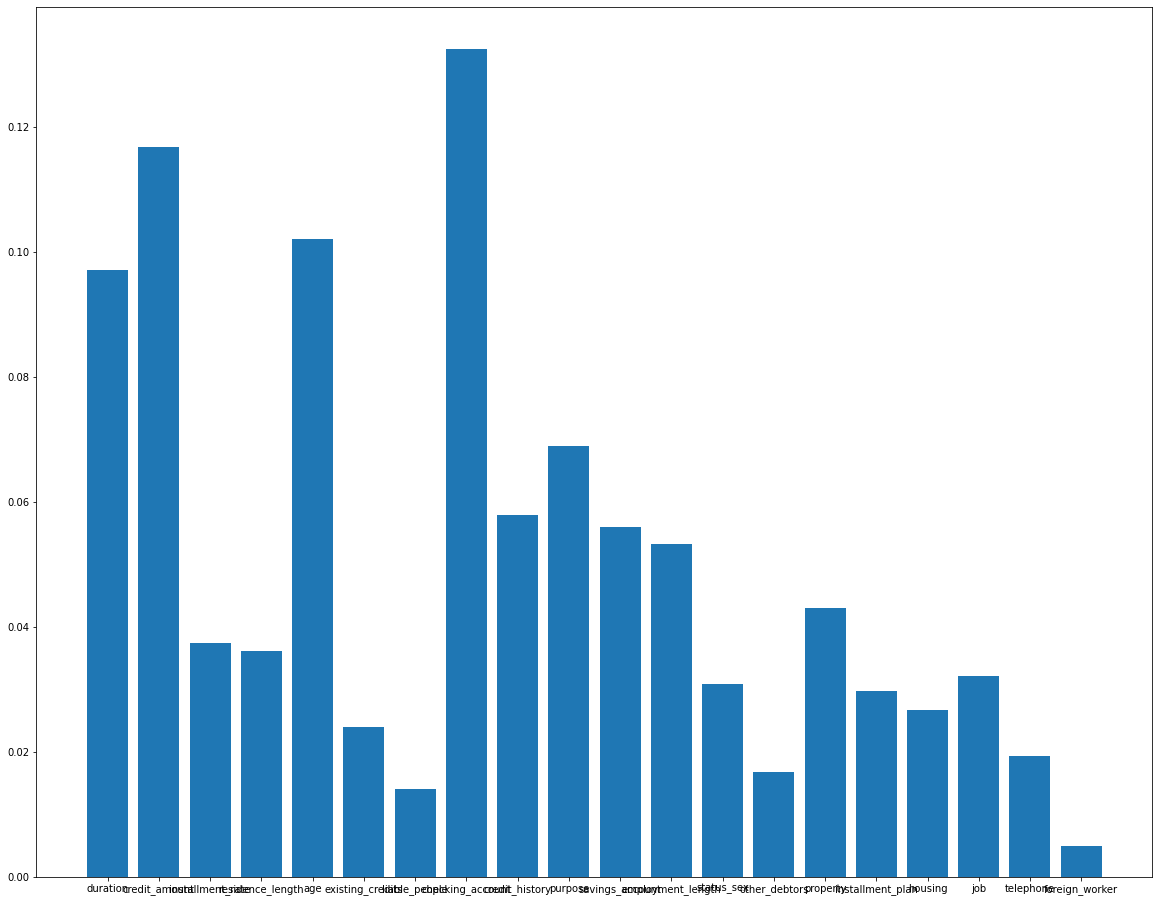

[ True  True  True False  True False False  True  True  True  True  True
 False False  True False False False False False]
10
Index(['duration', 'credit_amount', 'installment_rate', 'age',
       'checking_account', 'credit_history', 'purpose', 'savings_account',
       'employment_length', 'property'],
      dtype='object')


In [ ]:
model.fit(df_X_train, np.ravel(df_y_train))
importance = model.feature_importances_
 
plt.figure(figsize=(20,16))
plt.bar([df_X_train.columns[x] for x in range(len(importance))], importance)
plt.show()

bool_selection = (importance >= np.median(importance))
print(bool_selection)
print(np.sum(bool_selection))

#selector = SelectFromModel(LogisticRegression(solver='liblinear', penalty="l1"), threshold = '1.25*median')
#selector.fit(df_X_train, df_y_train)
#print(selector.get_support())
print(df_X_train.loc[:, bool_selection].columns)
df_X_train_selected = df_X_train.loc[:, bool_selection]
df_X_val_selected = df_X_val.loc[:, bool_selection]

### 3.5 Re-tune the hyperparameters using selected features

In [ ]:
model = RandomForestClassifier()
hyperparam_grid_1 = {'n_estimators': [25, 50, 100, 200, 300, 500, 700, 1000]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_1, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)


Fitting 15 folds for each of 8 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.4min finished


0.7864990388312186
{'n_estimators': 500}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
model = RandomForestClassifier(n_estimators=1000)
hyperparam_grid_2 = {'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid_2, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

model_bestparam_selected = grid_search.best_estimator_
print(model_bestparam_selected)

Fitting 15 folds for each of 24 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 11.0min finished


0.7907907215173651
{'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       

[[88 65]
 [ 6 41]]
              precision    recall  f1-score   support

        good       0.94      0.58      0.71       153
         bad       0.39      0.87      0.54        47

    accuracy                           0.65       200
   macro avg       0.66      0.72      0.62       200
weighted avg       0.81      0.65      0.67       200

0.7237519121123627


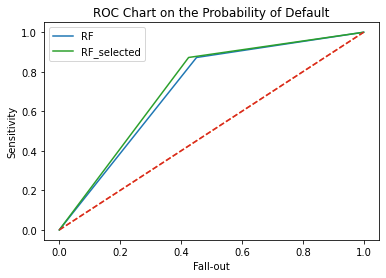

it seems that feature selection is not very effective.


In [ ]:

preds = model_bestparam_selected.predict_proba(df_X_val_selected)
df_preds_selected  = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.4
df_preds_selected['Risk_pred'] = df_preds_selected['prob_default'].apply(lambda x: 1 if x > threshold else 0)
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds_selected['Risk_pred']))
print(classification_report(df_y_val, df_preds_selected['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds_selected['Risk_pred']))

plot_roc_PD(df_preds['Risk_pred'], df_y_val, 'RF')
plot_roc_PD(df_preds_selected['Risk_pred'], df_y_val, 'RF_selected')
plt.show()


print("it seems that feature selection is not very effective.")

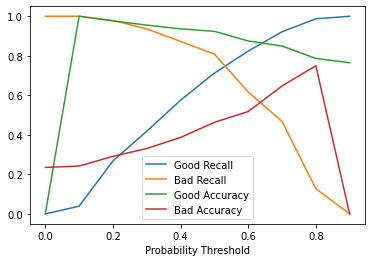

threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management


In [ ]:
plot_prob_thresh(df_preds_selected, df_y_val)
plt.show()

print("threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management")

### 3.6 Save the predicted validation data for comparision

In [ ]:
df_preds_selected.to_csv('df_preds_RF.csv')